# calculates the seasonal anomalies and the seasonal tercile categories from the gridded GCM

In [1]:
# Paramaters 
provider = 'JMA'
stage_in = 'processed'
period = 'hindcasts'
GCM = 'JMA'
var_name = 'PRECIP'
step = 3
remove_tmp = True

GCM list: 
    
    **CDS**: ECMWF, UKMO, METEO_FRANCE, DWD, CMCC
    
    **IRI**: NCEP_CFSv2, CanCM4i, CanSIPSv2, GEM_NEMO, NASA_GEOSS2S
    
    **JMA*: JMA

In [2]:
nz_domain = {}
nz_domain['lat_min'] = -50.
nz_domain['lat_max'] = -20.
nz_domain['lon_min'] = 100.
nz_domain['lon_max'] = 180.

In [3]:
%matplotlib inline 

In [4]:
from matplotlib import pyplot as plt

In [5]:
import sys

In [6]:
sys.path.append('../../utils')

### set the root directory for loading the GCM outputs files 

In [7]:
from set_root_dir import set_root_dir

In [8]:
dpath = set_root_dir(root='gdata')

In [9]:
print(dpath)

/media/nicolasf/GDATA/END19101/Working/data


In [10]:
import os
import pathlib
from subprocess import call
import shutil

In [11]:
import salem 
import geopandas as gpd 

In [12]:
import numpy as np
import pandas as pd 

In [13]:
import xarray as xr

In [14]:
from cartopy import crs as ccrs

In [15]:
from datetime import datetime, timedelta

In [16]:
import calendar

In [17]:
import dateutil

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [18]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [19]:
var_name

'PRECIP'

In [20]:
GCM

'JMA'

### set the home directory 

In [21]:
HOME = pathlib.Path.home() 

### set the working directory 

In [22]:
CWD = pathlib.Path.cwd()

#### input path for the GCM outputs 

In [23]:
ipath = dpath / 'GCMs' / stage_in / period / provider / GCM / var_name

In [24]:
ipath

PosixPath('/media/nicolasf/GDATA/END19101/Working/data/GCMs/processed/hindcasts/JMA/JMA/PRECIP')

In [25]:
lfiles_gcm = list((set_root_dir(root='local')  / 'GCMs' / stage_in / period / provider / GCM / var_name).glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc"))

In [26]:
lfiles_gcm.sort()

In [27]:
lfiles_gcm[0]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/JMA/JMA/PRECIP/JMA_PRECIP_seasonal_anomalies_1979_01.nc')

In [28]:
lfiles_gcm[-1]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/JMA/JMA/PRECIP/JMA_PRECIP_seasonal_anomalies_2019_12.nc')

In [29]:
ncks = "/home/nicolasf/anaconda3/envs/NCO/bin/ncks"

In [30]:
tmp_path = pathlib.Path.home() / 'data' / 'tmp'

In [31]:
if not tmp_path.exists(): 
    tmp_path.mkdir(parents=True)

In [32]:
tmp_path

PosixPath('/home/nicolasf/data/tmp')

### read files one by one (with SALEM), calculates the ensemble mean, select the step (3) extract the domain

In [33]:
for fname in lfiles_gcm: 
    if GCM == 'JMA': 
        cmd = f"{ncks} -d lat,{nz_domain['lat_min']},{nz_domain['lat_max']} -d lon,{nz_domain['lon_min']},{nz_domain['lon_max']} {str(fname)} {str(tmp_path / fname.name)}"
    else: 
        cmd = f"{ncks} -d lat,{nz_domain['lat_min']},{nz_domain['lat_max']} -d lon,{nz_domain['lon_min']},{nz_domain['lon_max']} -d step,{step}.,{step}. {str(fname)} {str(tmp_path / fname.name)}"
    r = call(cmd, shell=True)
    print(f"processed {fname.name}, ret code {r}")

processed JMA_PRECIP_seasonal_anomalies_1979_01.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_02.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_03.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_04.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_05.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_06.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_07.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_08.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_09.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_10.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_11.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1979_12.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1980_01.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1980_02.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1980_03.nc, ret code 0
processed JMA_PRECIP_seasonal_anomalies_1980_04.nc, ret

In [34]:
lfiles_tmp = list(tmp_path.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc")) 

In [35]:
lfiles_tmp.sort()

In [36]:
lfiles_tmp[0]

PosixPath('/home/nicolasf/data/tmp/JMA_PRECIP_seasonal_anomalies_1979_01.nc')

In [37]:
lfiles_tmp[-1]

PosixPath('/home/nicolasf/data/tmp/JMA_PRECIP_seasonal_anomalies_2019_12.nc')

### load the dataset, DO NOT calculate the ensemble average, as it could be good to increase the number of samples ...

In [38]:
dset_l = []
time_l = []
for fname in lfiles_tmp: 
    dset = salem.open_xr_dataset(fname)
    # here make sure that we drop potentially conflicting variables and coordinates
    if 'surface' in dset.variables: 
        dset = dset.drop('surface') 
    if 'valid_time' in dset.coords: 
        dset = dset.drop('valid_time')
#     dset = dset.mean('member') 
    if GCM != 'JMA':
        dset = dset.sel(step=step)
    time = pd.to_datetime(dset.time.data) + dateutil.relativedelta.relativedelta(month=step + 1)
    time_l.append(time)
    dset_l.append(dset)

In [39]:
dset = xr.concat(dset_l, dim='time')

In [40]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 33, member: 5, time: 492)
Coordinates:
  * member   (member) int64 0 1 2 3 4
  * lat      (lat) float64 -50.0 -47.5 -45.0 -42.5 ... -27.5 -25.0 -22.5 -20.0
  * lon      (lon) float64 100.0 102.5 105.0 107.5 ... 172.5 175.0 177.5 180.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    precip   (time, member, lat, lon) float64 0.9081 0.9137 ... 0.4181 0.3051
Attributes:
    history:     Mon Mar 30 16:39:28 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### open the target grid (1x1) onto which all the GCM will be interpolated (but for the JMA ?)

In [41]:
target_grid = xr.open_dataset(pathlib.Path(set_root_dir(root='local') / 'GCMs' / 'target_grid' / 'target_grid_1x1.nc'))

In [42]:
target_grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    *empty*

In [43]:
target_grid = target_grid.sel(lat=slice(nz_domain['lat_min'], nz_domain['lat_max']), lon=slice(nz_domain['lon_min'], nz_domain['lon_max']))

In [44]:
target_grid

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 80)
Coordinates:
  * lat      (lat) float64 -49.5 -48.5 -47.5 -46.5 ... -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
Data variables:
    *empty*

In [45]:
dset = dset.interp_like(target_grid)

In [46]:
dset

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 80, member: 5, time: 492)
Coordinates:
  * member   (member) int64 0 1 2 3 4
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
  * lat      (lat) float64 -49.5 -48.5 -47.5 -46.5 ... -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
Data variables:
    precip   (time, member, lat, lon) float64 0.7199 0.6988 ... 0.5679 0.4977
Attributes:
    history:     Mon Mar 30 16:39:28 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### only needed if the forecast period is mistakenly included in the hindcast folder 

In [47]:
if pd.to_datetime(dset.time[-1].data).year > 2016: 
    dset = dset.sel(time=slice(None, '2016'))

In [48]:
dset

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 80, member: 5, time: 456)
Coordinates:
  * member   (member) int64 0 1 2 3 4
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
  * lat      (lat) float64 -49.5 -48.5 -47.5 -46.5 ... -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
Data variables:
    precip   (time, member, lat, lon) float64 0.7199 0.6988 ... 2.99 3.172
Attributes:
    history:     Mon Mar 30 16:39:28 2020: /home/nicolasf/anaconda3/envs/NCO/...
    NCO:         netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net...
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### shift the time index, to reflect the actual forecast valid time 

In [49]:
dset['time'] = dset.time.to_index().shift(step + 1, freq='M')

In [50]:
dset.time[0].data

array('1979-04-30T00:00:00.000000000', dtype='datetime64[ns]')

In [51]:
dset.time[-1].data

array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')

### reads the NZ 'melted' shapefile, see commented code below for how to dissolve shapes

In [52]:
# nz_regions = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

# nz_regions

# nz_regions = nz_regions.to_crs(epsg=4326)

# nz_regions.crs

# nz_regions.loc[:,'reg'] = 1

# nz = nz_regions.dissolve(by='reg')

# nz.loc[:,'Location'] = 'NZ'

# nz.to_file(set_root_dir(root='local') / 'shapefiles' / "NZ.json", driver="GeoJSON")

In [53]:
nz = gpd.read_file(set_root_dir(root='local') / 'shapefiles' / "NZ" / "NZ.json") 

In [54]:
nz.crs

{'init': 'epsg:4326'}

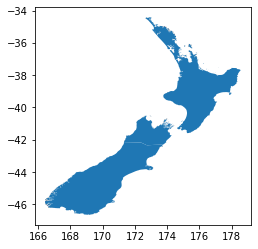

In [55]:
nz.plot()

### check the CRS 

In [56]:
if not (nz.crs['init'] == 'epsg:4326'): 
    print('\n\nWARNING: the CRS for NZ is not lat lon! ')

### defines the output path 

In [57]:
opath = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'GCMs' / 'NZ_shape_grid' / GCM / var_name

In [58]:
if not opath.exists(): 
    opath.mkdir(parents=True)

### extract and plots the regions subset and ROIs, just plot the first member of the ensemble ... 

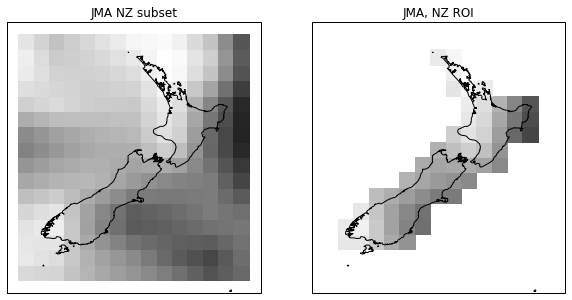

In [59]:
f, axes = plt.subplots(figsize=(10, 5), ncols=2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}) 

nat = dset.salem.subset(shape=nz, margin=2)

nat[var_name.lower()][0,0,:,:].plot(ax=axes[0], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

axes[0].coastlines(resolution='10m')

axes[0].set_title(f'{GCM} NZ subset')

if ((nat.dims['lat'] > 1) & (nat.dims['lon'] > 1)):

    nat = nat.salem.roi(shape=nz, all_touched=True)

    nat[var_name.lower()][0,0,:,:].plot(ax=axes[1], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='binary')

    axes[1].coastlines(resolution='10m')

    axes[1].set_title(f'{GCM}, NZ ROI')

f.savefig(CWD.parents[2] / 'figures' / f'subset_and_ROI_map_{GCM}_NZ.png', dpi=200, bbox_inches='tight')

### saves to disk 

In [60]:
pd.to_datetime(nat.time[0].data)

Timestamp('1979-04-30 00:00:00')

In [61]:
pd.to_datetime(nat.time[-1].data)

Timestamp('2017-03-31 00:00:00')

In [62]:
nat.to_netcdf(opath / f"NZ_nat_{GCM}_{var_name}_{pd.to_datetime(nat.time[0].data):%Y-%m}_{pd.to_datetime(nat.time[-1].data):%Y-%m}.nc") 

In [63]:
opath

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/GCMs/NZ_shape_grid/JMA/PRECIP')

In [64]:
print(f"\n\n\nPROCESSING FINISHED FOR {GCM} -> {var_name}")




PROCESSING FINISHED FOR JMA -> PRECIP


In [65]:
!pwd

/home/nicolasf/research/Smart_Ideas/code/targets/GCM


In [71]:
df = nat.mean(dim=['lat','lon']).to_dataframe()

In [80]:
df = df.loc[:,['precip']].unstack().T

In [84]:
df = df.droplevel(0)

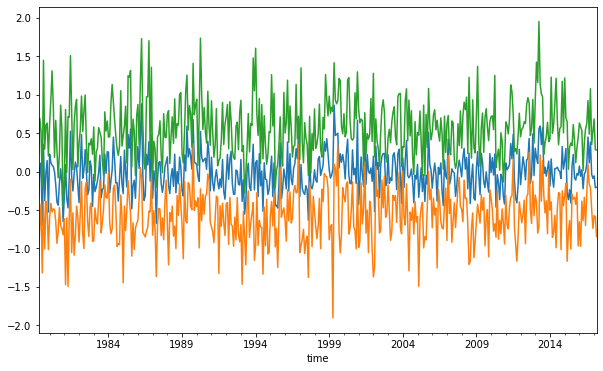

In [93]:
f, ax = plt.subplots(figsize=(10, 6))
df.mean(axis=1).plot(ax=ax)
df.min(axis=1).plot(ax=ax)
df.max(axis=1).plot(ax=ax)